In [335]:
#libraries/Packages versions used for this Project
!pip list

Package               Version
--------------------- -----------
appnope               0.1.0
as                    0.1
astropy               4.0.1.post1
attrs                 19.3.0
backcall              0.2.0
bleach                3.1.5
Brotli                1.0.7
category-encoders     2.2.2
certifi               2020.6.20
chardet               3.0.4
click                 7.1.2
confuse               1.3.0
cycler                0.10.0
dash                  1.13.4
dash-core-components  1.10.1
dash-html-components  1.0.3
dash-renderer         1.5.1
dash-table            4.8.1
decorator             4.4.2
defusedxml            0.6.0
eli5                  0.10.1
entrypoints           0.3
Flask                 1.1.2
Flask-Compress        1.5.0
future                0.18.2
graphviz              0.14.1
htmlmin               0.1.12
idna                  2.10
ImageHash             4.1.0
importlib-metadata    1.7.0
ipykernel             5.3.2
ipython               7.16.1
ipython-genutils      0.2.

In [377]:
#Installing main libaries used in this project
!pip install -U scikit-learn
!pip install matplotlib
!pip install sklearn
!pip install shap
!pip install joblib
!pip install pdpbox
import xgboost
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('max_columns', 40)

Requirement already up-to-date: scikit-learn in /Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages (0.23.1)


In [337]:
#importing data
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/JonRivera/JonRivera.github.io/master/Unit2/Buil_Week/Data_Sets/Hotel_Bookings/hotel_bookings.csv")

## EXPLORATORY ANALYSIS 


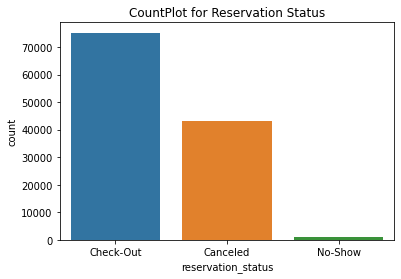

In [338]:
target = 'reservation_status'
sns.countplot(df['reservation_status'])
plt.title('CountPlot for Reservation Status');

In [339]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## WRANGLE DATA

In [340]:
def wrangle(df):
    df = df.copy()
    #drop unecessary columns, or columns that seem to have little impact on target
    df = df.drop(['company', 'agent','arrival_date_week_number'],axis = 1)
    df = df.dropna(axis=0)  
    
    #set date column to index
    #doesn't add any substantial info, and has high cardinality. 
    df.set_index(pd.to_datetime(df['reservation_status_date']), inplace = True)
    df = df.drop(['reservation_status_date'], axis=1)
    
    
    #I am treating cancelations as people who canceled or did not show
    #on there arrival date --- it was assumend the hotel would treat 
    df['reservation_status'] =  df['reservation_status'].replace({'No-Show':'Canceled'})
    
    #features selected based on feature imporances
    features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'previous_cancellations',
                'booking_changes', 'adr', 'required_car_parking_spaces', 'country', 'deposit_type']
    return df,features
df,features = wrangle(df)


## TRAIN, VALIDATE, TEST SPLIT

In [341]:
#get train, validate,and test subsets
train = df[df['arrival_date_year']==2015].copy()
val = df[df['arrival_date_year']==2016].copy()
test = df[df['arrival_date_year'] == 2017].copy()
train.shape, val.shape, test.shape

((21859, 28), (56435, 28), (40604, 28))

In [342]:
#seperating X matrices and correspind y vectors
target = 'reservation_status'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val= val[features]
y_val = val[target]
X_train.shape,y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape

((21859, 9), (21859,), (56435, 9), (56435,), (40604, 9), (40604,))

## BASELINE

In [343]:
#baselines
#Training Baseline
y_train.value_counts(normalize=True)


Check-Out    0.629169
Canceled     0.370831
Name: reservation_status, dtype: float64

In [344]:
#Validation Baseline
y_val.value_counts(normalize=True)


Check-Out    0.640064
Canceled     0.359936
Name: reservation_status, dtype: float64

In [374]:
#instantitate classes

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import category_encoders as ce
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [346]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

## Model0- Random Tree Forest Classifier

In [347]:
#Build pipeline using RadnomSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
model0 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs = -1, random_state=40)

)

param_distributions = { 
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': [5,10,20],
    'randomforestclassifier__min_samples_split': [5,10,15,20],
    'randomforestclassifier__min_samples_leaf': [2]
}
search = RandomizedSearchCV(
    model0, 
    param_distributions = param_distributions,
    n_iter = 10,
    cv=10,
    scoring ='accuracy',
    verbose = 1,
    return_train_score = True,
    n_jobs = -1
)

search.fit(X_train, y_train)
print('Cross-validation Best Score', search.best_score_)
print('Best Estimator:' ,search.best_params_)
print('Best Model', search.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.4s finished


Cross-validation Best Score 0.8398872584221204
Best Estimator: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__criterion': 'entropy'}
Best Model Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'deposit_type'],
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': PRT     1
GBR     2
USA     3
ESP     4
IRL     5
       ..
GEO    95
TMP    96
MUS    97
ECU    98
NaN    -2
Length: 99, dtype: int64},
                                         {'col': 'deposit_type',
                                          'data_type': dtype('O'),
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: int64}])),
        

In [348]:
model0 = search.best_estimator_
model0

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'deposit_type'],
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': PRT     1
GBR     2
USA     3
ESP     4
IRL     5
       ..
GEO    95
TMP    96
MUS    97
ECU    98
NaN    -2
Length: 99, dtype: int64},
                                         {'col': 'deposit_type',
                                          'data_type': dtype('O'),
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_features=5,
                                        min_samples_leaf=2,
                                        min_samples_split=10, n_jobs=-1,
          

In [349]:
y_pred0 = model0.predict(X_val)
y_pred_probab0 = model0.predict_proba(X_val)

In [350]:
print('Random Forest Classifier Classification Report')
print(classification_report(y_val, y_pred0))

Random Forest Classifier Classification Report
              precision    recall  f1-score   support

    Canceled       0.85      0.45      0.59     20313
   Check-Out       0.76      0.95      0.84     36122

    accuracy                           0.77     56435
   macro avg       0.80      0.70      0.72     56435
weighted avg       0.79      0.77      0.75     56435



In [351]:
roc_auc_score(y_val,y_pred_probab0[:,1])

0.7569918898358675

In [352]:
accuracy_score(y_val,y_pred0)

0.7733675910339328

## Model1 - XGBOOST 

Run XGBoost w/ Early Stopping to prevent overfitting and optimize n_estimators.

In [353]:
from xgboost.sklearn import XGBClassifier
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model1 = XGBClassifier(
        n_estimators = 20, 
        max_depth = 5,
        learning_rate = .5,
        n_jobs = -1

)


model1.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluation Metrics


In [354]:
#Helps me identify the order of the class labels in the target
model1.classes_ 

array(['Canceled', 'Check-Out'], dtype=object)

In [355]:
y_pred1 = model1.predict(X_val_encoded)
y_pred_probab1 = model1.predict_proba(X_val_encoded)

In [356]:
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

    Canceled       0.88      0.43      0.57     20313
   Check-Out       0.75      0.97      0.84     36122

    accuracy                           0.77     56435
   macro avg       0.81      0.70      0.71     56435
weighted avg       0.79      0.77      0.75     56435



In [357]:
roc_auc_score(y_val,y_pred_probab1[:,1])

0.7782593775553881

In [358]:
accuracy_score(y_val,y_pred1)

0.7716842385044742


## Model2 - Logistic Regression

In [375]:
#Improved logistic regression model by hyperparameter tunning
#Max iterations
model2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LogisticRegression(random_state=40, max_iter = 200)
)
model2.fit(X_train, y_train)



Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'deposit_type'],
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': PRT     1
GBR     2
USA     3
ESP     4
IRL     5
       ..
GEO    95
TMP    96
MUS    97
ECU    98
NaN    -2
Length: 99, dtype: int64},
                                         {'col': 'deposit_type',
                                          'data_type': dtype('O'),
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression',
                 LogisticRegression(max_iter=200, random_state=40))])

## ROCAUC Curve for Model 0, Model1,Model2

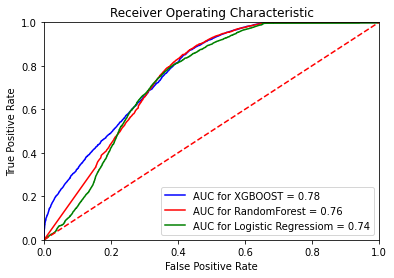

In [376]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

probs2 = model2.predict_proba(X_val)
preds2 = probs2[:,1]
fpr2,tpr2, threshold = metrics.roc_curve(y_val,preds2, pos_label='Check-Out')
roc_auc2 = metrics.auc(fpr2,tpr2)

probs1 = model1.predict_proba(X_val_encoded)
preds1 = probs1[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(y_val, preds1, pos_label='Check-Out')
roc_auc1 = metrics.auc(fpr1, tpr1)

probs0 = model0.predict_proba(X_val)
preds0 = probs0[:,1]
fpr0, tpr0, threshold = metrics.roc_curve(y_val, preds0, pos_label ='Check-Out')
roc_auc0 = metrics.auc(fpr0, tpr0)



# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC for XGBOOST = %0.2f' % roc_auc1)
plt.plot(fpr0, tpr0, 'r', label = 'AUC for RandomForest = %0.2f' % roc_auc0)
plt.plot(fpr2, tpr2, 'g', label = 'AUC for Logistic Regressiom = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Plotly Dash App Steps

In [361]:

import joblib
from joblib import dump

In [362]:
#Check Versions libary versions used
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')

joblib==0.16.0
scikit-learn==0.23.1
category_encoders==2.2.2
xgboost==1.1.0


In [363]:
#Checking memory size of pipeline
!ls -lh model3.joblib

-rw-r--r--  1 johnrivera  staff    18K Jul 28 12:45 model3.joblib


In [364]:
#Checking xgboost format
model1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [365]:
#Plug model1 into make_pipeline and fit it to orginal X_train,y_train
#Otherwise I encounter difficulties with dashapp
#Dash app uses scikitlearn pipline format
#Model3 is the same as model1, it's just in make_pipeline format
#Encoding happens inside the pipeline as well
model3 = make_pipeline(ce.OrdinalEncoder(),model1)
model3

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.5,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=20,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [366]:
#Originally I was working with my xgboost for my dash app, however
#When I upload to heroku, I get problems with xgboost
#I change from model3 to model0 so things ran smoothly in heroku
#Xgboost works locally though
dump(model0, 'model0.joblib', compress=True)

['model0.joblib']

In [367]:
X_train['deposit_type'].value_counts()

No Deposit    18202
Non Refund     3653
Refundable        4
Name: deposit_type, dtype: int64

In [368]:
#Creating function for dash app
def predict(lead_time,stays_in_weekend_nights,stays_in_week_nights,
               previous_cancellations,booking_changes,adr,required_car_parking_spaces,country,deposit_type):
    df = pd.DataFrame(
        columns= ['lead_time','stays_in_weekend_nights','stays_in_week_nights',
                  'previous_cancellations','booking_changes','adr','required_car_parking_spaces',
                  'country','deposit_type']
            
            ,
        data=[[lead_time,stays_in_weekend_nights,stays_in_week_nights,
               previous_cancellations,booking_changes,adr,required_car_parking_spaces,country,deposit_type]]
    )
    y_pred_probab0 = round(model0.predict_proba(df)[0][0],2)
    y_pred = model0.predict(df)[0]
    print(f' Probabillity that person checked-out {y_pred_probab0}%')
    return f'Person {y_pred} Booking.'


In [369]:
#Testing predict function
predict(7,20,20,0,2,10,0,'USA','Non Refund')

 Probabillity that person checked-out 0.46%


'Person Check-Out Booking.'

In [371]:
#Checking versions of main libraries used
#Helps me create the proper virtual environment for my dashly app to run on
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')


joblib==0.16.0
scikit-learn==0.23.1
category_encoders==2.2.2
xgboost==1.1.0


In [372]:
#creating features for dashly app
country_names = list(df['country'].value_counts().index)
column2 = pd.Series(country_names)
df2.columns = ['label','value']
df2.to_dict('records')
#These list of dicitionaries will be used to make an interactive feature in the plotly dash app

[{'label': 'PRT', 'value': 'PRT'},
 {'label': 'GBR', 'value': 'GBR'},
 {'label': 'FRA', 'value': 'FRA'},
 {'label': 'ESP', 'value': 'ESP'},
 {'label': 'DEU', 'value': 'DEU'},
 {'label': 'ITA', 'value': 'ITA'},
 {'label': 'IRL', 'value': 'IRL'},
 {'label': 'BEL', 'value': 'BEL'},
 {'label': 'BRA', 'value': 'BRA'},
 {'label': 'NLD', 'value': 'NLD'},
 {'label': 'USA', 'value': 'USA'},
 {'label': 'CHE', 'value': 'CHE'},
 {'label': 'CN', 'value': 'CN'},
 {'label': 'AUT', 'value': 'AUT'},
 {'label': 'SWE', 'value': 'SWE'},
 {'label': 'CHN', 'value': 'CHN'},
 {'label': 'POL', 'value': 'POL'},
 {'label': 'ISR', 'value': 'ISR'},
 {'label': 'RUS', 'value': 'RUS'},
 {'label': 'NOR', 'value': 'NOR'},
 {'label': 'ROU', 'value': 'ROU'},
 {'label': 'FIN', 'value': 'FIN'},
 {'label': 'DNK', 'value': 'DNK'},
 {'label': 'AUS', 'value': 'AUS'},
 {'label': 'AGO', 'value': 'AGO'},
 {'label': 'LUX', 'value': 'LUX'},
 {'label': 'MAR', 'value': 'MAR'},
 {'label': 'TUR', 'value': 'TUR'},
 {'label': 'HUN', 'value': 'HUN'},
 {'label': 'ARG', 'value': 'ARG'},
 {'label': 'JPN', 'value': 'JPN'},
 {'label': 'CZE', 'value': 'CZE'},
 {'label': 'IND', 'value': 'IND'},
 {'label': 'KOR', 'value': 'KOR'},
 {'label': 'GRC', 'value': 'GRC'},
 {'label': 'DZA', 'value': 'DZA'},
 {'label': 'SRB', 'value': 'SRB'},
 {'label': 'HRV', 'value': 'HRV'},
 {'label': 'MEX', 'value': 'MEX'},
 {'label': 'IRN', 'value': 'IRN'},
 {'label': 'EST', 'value': 'EST'},
 {'label': 'LTU', 'value': 'LTU'},
 {'label': 'ZAF', 'value': 'ZAF'},
 {'label': 'BGR', 'value': 'BGR'},
 {'label': 'NZL', 'value': 'NZL'},
 {'label': 'COL', 'value': 'COL'},
 {'label': 'UKR', 'value': 'UKR'},
 {'label': 'MOZ', 'value': 'MOZ'},
 {'label': 'CHL', 'value': 'CHL'},
 {'label': 'SVK', 'value': 'SVK'},
 {'label': 'THA', 'value': 'THA'},
 {'label': 'SVN', 'value': 'SVN'},
 {'label': 'ISL', 'value': 'ISL'},
 {'label': 'LVA', 'value': 'LVA'},
 {'label': 'TWN', 'value': 'TWN'},
 {'label': 'CYP', 'value': 'CYP'},
 {'label': 'ARE', 'value': 'ARE'},
 {'label': 'SAU', 'value': 'SAU'},
 {'label': 'PHL', 'value': 'PHL'},
 {'label': 'TUN', 'value': 'TUN'},
 {'label': 'SGP', 'value': 'SGP'},
 {'label': 'IDN', 'value': 'IDN'},
 {'label': 'NGA', 'value': 'NGA'},
 {'label': 'URY', 'value': 'URY'},
 {'label': 'EGY', 'value': 'EGY'},
 {'label': 'LBN', 'value': 'LBN'},
 {'label': 'PER', 'value': 'PER'},
 {'label': 'HKG', 'value': 'HKG'},
 {'label': 'MYS', 'value': 'MYS'},
 {'label': 'ECU', 'value': 'ECU'},
 {'label': 'VEN', 'value': 'VEN'},
 {'label': 'BLR', 'value': 'BLR'},
 {'label': 'CPV', 'value': 'CPV'},
 {'label': 'GEO', 'value': 'GEO'},
 {'label': 'JOR', 'value': 'JOR'},
 {'label': 'KAZ', 'value': 'KAZ'},
 {'label': 'CRI', 'value': 'CRI'},
 {'label': 'OMN', 'value': 'OMN'},
 {'label': 'MLT', 'value': 'MLT'},
 {'label': 'GIB', 'value': 'GIB'},
 {'label': 'AZE', 'value': 'AZE'},
 {'label': 'MAC', 'value': 'MAC'},
 {'label': 'KWT', 'value': 'KWT'},
 {'label': 'QAT', 'value': 'QAT'},
 {'label': 'PAK', 'value': 'PAK'},
 {'label': 'DOM', 'value': 'DOM'},
 {'label': 'IRQ', 'value': 'IRQ'},
 {'label': 'BIH', 'value': 'BIH'},
 {'label': 'PRI', 'value': 'PRI'},
 {'label': 'BGD', 'value': 'BGD'},
 {'label': 'MDV', 'value': 'MDV'},
 {'label': 'ALB', 'value': 'ALB'},
 {'label': 'SEN', 'value': 'SEN'},
 {'label': 'BOL', 'value': 'BOL'},
 {'label': 'CMR', 'value': 'CMR'},
 {'label': 'MKD', 'value': 'MKD'},
 {'label': 'PAN', 'value': 'PAN'},
 {'label': 'GNB', 'value': 'GNB'},
 {'label': 'TJK', 'value': 'TJK'},
 {'label': 'VNM', 'value': 'VNM'},
 {'label': 'JEY', 'value': 'JEY'},
 {'label': 'LBY', 'value': 'LBY'},
 {'label': 'ARM', 'value': 'ARM'},
 {'label': 'CUB', 'value': 'CUB'},
 {'label': 'AND', 'value': 'AND'},
 {'label': 'MUS', 'value': 'MUS'},
 {'label': 'LKA', 'value': 'LKA'},
 {'label': 'KEN', 'value': 'KEN'},
 {'label': 'CIV', 'value': 'CIV'},
 {'label': 'JAM', 'value': 'JAM'},
 {'label': 'FRO', 'value': 'FRO'},
 {'label': 'BHR', 'value': 'BHR'},
 {'label': 'MNE', 'value': 'MNE'},
 {'label': 'TZA', 'value': 'TZA'},
 {'label': '